In [79]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from mhkit import wave
import pandas as pd
import os
import yaml
import re
from pathlib import Path
from scipy.special import hankel1 as Hankel

In [80]:
# Determine root_dir
if "__file__" in globals():
    # Running as a script
    script_dir = os.path.dirname(os.path.abspath(__file__))
else:
    script_dir = os.getcwd()

# Traverse up to WEC-DECIDER root
root_dir = os.path.abspath(os.path.join(script_dir, "..", ".."))  
cem_dir = os.path.join(root_dir, "modules", "CEM")

In [81]:

data_type = '3-hour'
year = [2010]
parameters = [
    'omni-directional_wave_power',
    'significant_wave_height',
    'energy_period',
    'directionality_coefficient',
    'maximum_energy_direction',
    'mean_absolute_period',
    'mean_zero-crossing_period',
    'peak_period',
    'spectral_width'
]
lat_lon = (43.5, -70) # off coast of Maine
data, metadata = wave.io.hindcast.hindcast.request_wpto_point_data(data_type, parameters, lat_lon, year)
data.head()

,omni-directional_wave_power_0,significant_wave_height_0,energy_period_0,directionality_coefficient_0,maximum_energy_direction_0,mean_absolute_period_0,mean_zero-crossing_period_0,peak_period_0,spectral_width_0
time_index,,,,,,,,,
2010-01-01 00:00:00+00:00,1250.461548,0.59368,4.0172,0.898,172.5,4.9468,7.1971,10.9619,0.5247
2010-01-01 03:00:00+00:00,1488.557739,0.61967,4.1974,0.792,142.5,5.2501,7.7880,12.0135,0.5248
2010-01-01 06:00:00+00:00,1397.676758,0.60245,4.2983,0.797,127.5,5.3097,7.7302,12.0135,0.5230
2010-01-01 09:00:00+00:00,1351.827881,0.59589,4.3503,0.807,127.5,5.3221,7.6388,12.0135,0.5241
2010-01-01 12:00:00+00:00,1342.985474,0.59008,4.4666,0.825,127.5,5.4596,7.7342,12.0135,0.5120


In [82]:
data_mod = data.copy()

rho_w = 1025  # kg/m^3, density of water
g = 9.81  # m/s^2, acceleration due to gravity
#J_calc = data_mod["significant_wave_height_0"]**2 * rho_w * g**2 / (64 * np.pi) * data_mod["energy_period_0"]
J_calc = data_mod["significant_wave_height_0"]**2 * rho_w * g**2 / (64 * np.pi) * data_mod["mean_zero-crossing_period_0"]
fudge = 1 - .007 * (data_mod["mean_zero-crossing_period_0"] - (2*np.pi)) 
data_mod["Power_density_predicted"] = J_calc / fudge #/ data_mod["spectral_width_0"] #* data_mod["directionality_coefficient_0"]
data_mod["ratio_power_density"] = data_mod["omni-directional_wave_power_0"] / data_mod["Power_density_predicted"]

data_mod.head()


,omni-directional_wave_power_0,significant_wave_height_0,energy_period_0,directionality_coefficient_0,maximum_energy_direction_0,mean_absolute_period_0,mean_zero-crossing_period_0,peak_period_0,spectral_width_0,Power_density_predicted,ratio_power_density
time_index,,,,,,,,,,,
2010-01-01 00:00:00+00:00,1250.461548,0.59368,4.0172,0.898,172.5,4.9468,7.1971,10.9619,0.5247,1252.511475,0.998363
2010-01-01 03:00:00+00:00,1488.557739,0.61967,4.1974,0.792,142.5,5.2501,7.7880,12.0135,0.5248,1482.783813,1.003894
2010-01-01 06:00:00+00:00,1397.676758,0.60245,4.2983,0.797,127.5,5.3097,7.7302,12.0135,0.5230,1390.548584,1.005126
2010-01-01 09:00:00+00:00,1351.827881,0.59589,4.3503,0.807,127.5,5.3221,7.6388,12.0135,0.5241,1343.476685,1.006216
2010-01-01 12:00:00+00:00,1342.985474,0.59008,4.4666,0.825,127.5,5.4596,7.7342,12.0135,0.5120,1334.759277,1.006163


Text(0, 0.5, 'J calc / J ')

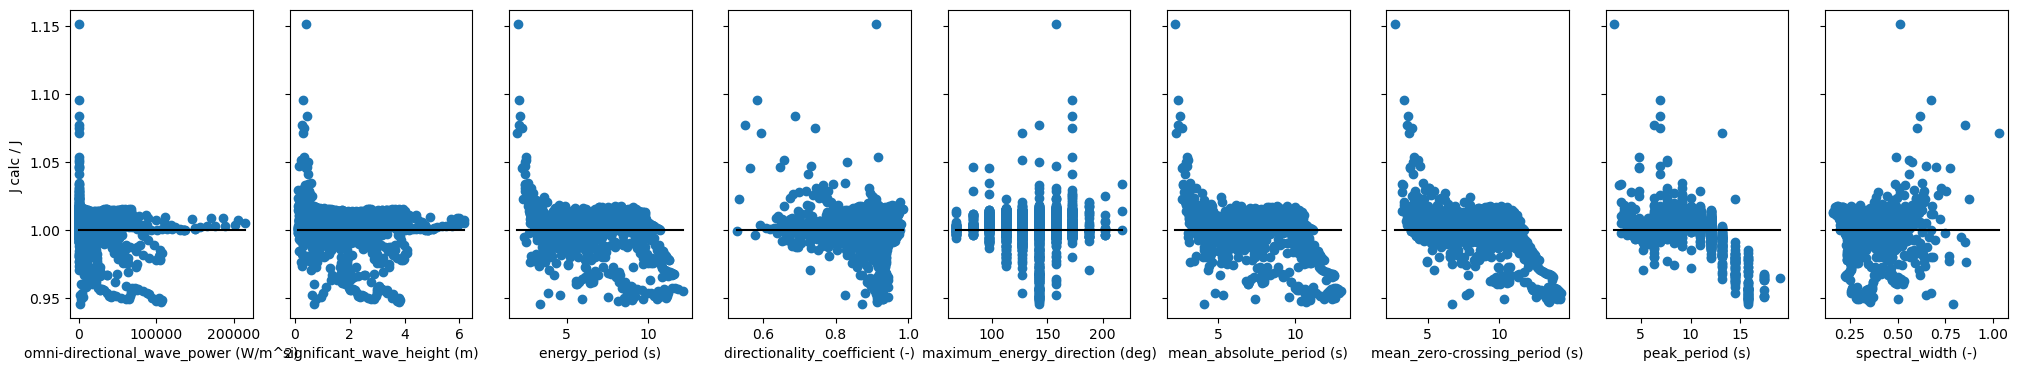

In [83]:
fig, ax = plt.subplots(1, parameters.__len__(), sharey=True, figsize=(25, 4))
units = ["W/m^2", "m", "s", "-", "deg", "s", "s", "s", "-"]
for i in range(parameters.__len__()):
    col = parameters[i] + "_0"
    if False: #"period" in col and col != "energy_period_0":
        normalize = True
        norm = data_mod["energy_period_0"]
    else:
        norm = 1
        normalize = False
    x_data = data_mod[col] / norm
    ax[i].scatter(x_data, 1/data_mod["ratio_power_density"])
    label = parameters[i] + " (" + units[i] + ")"
    if normalize:
        label += " / " + "energy_period" + " (s)"
    ax[i].set_xlabel(label)
    ax[i].plot([x_data.min(), x_data.max()], [1, 1], color='k')
ax[0].set_ylabel("J calc / J ")

In [84]:
# capture width
G = 1 # gain for heave (=2 for surge/pitch)
omega = 2 * np.pi / data_mod["mean_zero-crossing_period_0"]

zeta_range = [0.05, 0.15, 0.25]#[0.01, 0.05, 0.1, 0.2, 1]
omega_n_range = [0.5, 0.6, 0.7]#[0.4, 0.5, 0.6, 0.7, 1.5]
float_diam_range = [20] #[5, 15, 25, 35]  # in meters

ZETA, OMEGA, OMEGA_N, D_f = np.meshgrid(zeta_range, omega, omega_n_range, float_diam_range)

h = 85 # water depth in meters
k = wave.resource.wave_number(omega/ (2*np.pi), h)  # wave number
_,K,_,_ = np.meshgrid(zeta_range, k, omega_n_range, float_diam_range) # wave number mesh, to mimic omega mesh
mag_B_0_e_nondim = -0.0898 * K + 0.0217 # see fit in MDOcean/dev/B_0_e_vs_frequency.m
mag_B_0_e = mag_B_0_e_nondim * h 

denom = np.cosh(K*h) * np.abs(Hankel(0,K*D_f/2))
N_0 = 1 / 2 * (1 + np.sinh(2 * K * h) / (2 * K * h))
mag_F_over_eta = 4 * rho_w * g * h * N_0**(1/2) * mag_B_0_e / denom
curly_D = np.tanh(K*h) + K*h*(1 - np.tanh(K*h)**2)
B_h = mag_F_over_eta**2 / (2 * rho_w * g**2) * K * OMEGA / curly_D
B_u = B_h
CW_max = G * g / OMEGA**2 # radiation limit

real = 1 - (OMEGA / OMEGA_N)**2
imag = 2 * ZETA * OMEGA / OMEGA_N
mag_RAO_sq = 1/( real**2 + imag**2 )
CW_frac_raw = 2 * B_u * OMEGA**5 * mag_RAO_sq / (G * g**3 * rho_w)
CW_frac = np.minimum(CW_frac_raw, 1)
CW = CW_frac * CW_max

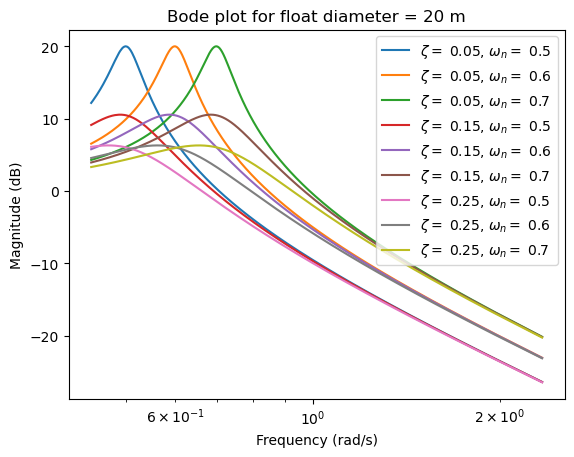

In [85]:
# bode plot to check mag RAO

for d_idx in range(len(float_diam_range)):
    fig, ax = plt.subplots()
    for z_idx in range(len(zeta_range)):
        for o_idx in range(len(omega_n_range)):
        
            x_data = OMEGA[:, z_idx, o_idx, d_idx]
            y_data = 20 * np.log10(np.sqrt(mag_RAO_sq[:, z_idx, o_idx, d_idx]))
            sorted_indices = np.argsort(x_data)
            x_data = x_data[sorted_indices]
            y_data = y_data[sorted_indices]
            ax.semilogx(x_data, y_data, label="$\zeta =$ " + str(zeta_range[z_idx]) + ", $\omega_n =$ " + str(omega_n_range[o_idx]))
    ax.set_xlabel("Frequency (rad/s)")
    ax.set_ylabel("Magnitude (dB)")
    ax.set_title("Bode plot for float diameter = " + str(float_diam_range[d_idx]) + " m")
    ax.legend()

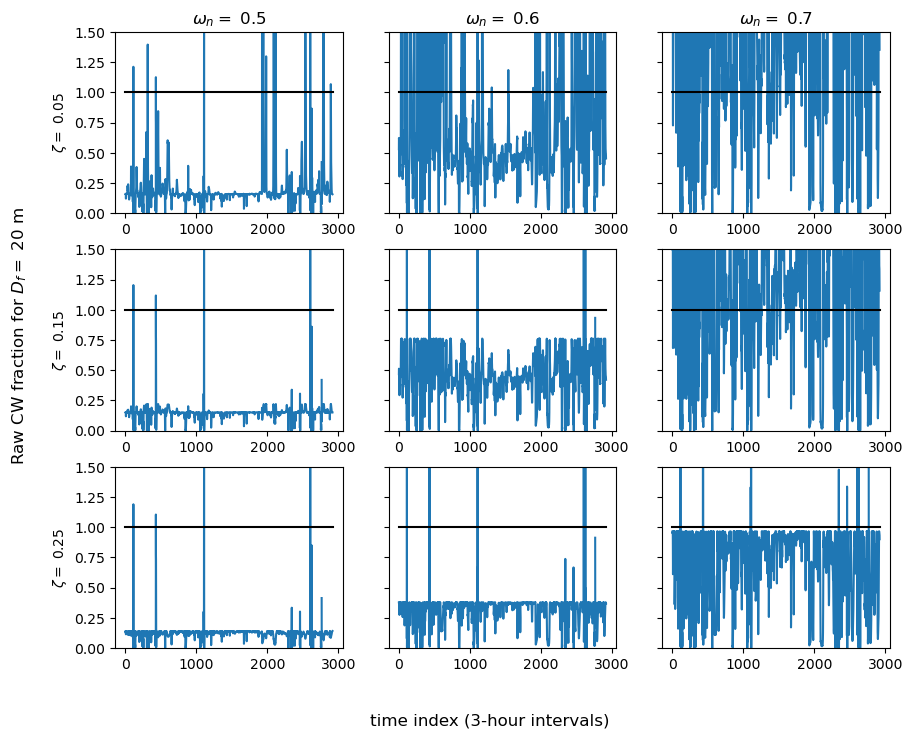

In [86]:
# plot time series of CW fraction
for d_idx in range(len(float_diam_range)):
    fig, ax = plt.subplots(len(zeta_range), len(omega_n_range), sharey=True, figsize=(10,8))
    for z_idx in range(len(zeta_range)):
        for o_idx in range(len(omega_n_range)):
            ax[z_idx, o_idx].plot(CW_frac_raw[:, z_idx, o_idx])
            ax[z_idx, o_idx].plot([0, len(CW_frac_raw[:, z_idx, o_idx])], [1, 1], 'k')
            if z_idx == 0:
                ax[z_idx, o_idx].set_title("$\omega_n =$ " + str(omega_n_range[o_idx]))
            if o_idx == 0:
                ax[z_idx, o_idx].set_ylabel("$\zeta =$ " + str(zeta_range[z_idx]))
            ax[z_idx, o_idx].set_ylim([0, 1.5])
    fig.supxlabel("time index (3-hour intervals)")
    fig.supylabel("Raw CW fraction for $D_f =$ " + str(float_diam_range[d_idx]) + " m")

In [87]:
# Apply different power limits for each zeta and omega_n
P_lim_list = np.concatenate( (np.linspace(0.005, 0.025, num=5), np.linspace(0.03, 0.09, num=7), np.linspace(0.1,0.9,num=9)) )

for d_idx in range(len(float_diam_range)):
    for z_idx in range(len(zeta_range)):
        for o_idx in range(len(omega_n_range)):
            key_unlimited = "Avail_zeta_" + str(zeta_range[z_idx]) + "_omega_n_" + str(omega_n_range[o_idx]) + "_D_f_" + str(float_diam_range[d_idx])
            data_unlimited = CW_frac[:, z_idx, o_idx, d_idx] / np.max(CW_frac[:, z_idx, o_idx, d_idx])
            for P_limit in P_lim_list:
                key_limited = key_unlimited + "_limited_" + str(int(P_limit*1000))
                data_mod[key_limited] = np.minimum(data_unlimited, P_limit) / P_limit
            data_mod[key_unlimited] = data_unlimited

data_mod = data_mod.copy() # unfragment dataframe
pd.set_option('display.max_rows', None)
means = data_mod.mean()
num_cols_added = 2
CFs = np.array(means)[(len(parameters)+num_cols_added):]
print(means)
print("Capacity factors: ",CFs)

omni-directional_wave_power_0                     10861.985352
significant_wave_height_0                             1.255046
energy_period_0                                       5.798270
directionality_coefficient_0                          0.894608
maximum_energy_direction_0                          138.585617
mean_absolute_period_0                                6.459770
mean_zero-crossing_period_0                           7.465244
peak_period_0                                         8.898335
spectral_width_0                                      0.327541
Power_density_predicted                           10847.621094
ratio_power_density                                   0.997325
Avail_zeta_0.05_omega_n_0.5_D_f_20_limited_5          0.992191
Avail_zeta_0.05_omega_n_0.5_D_f_20_limited_10         0.989533
Avail_zeta_0.05_omega_n_0.5_D_f_20_limited_15         0.987561
Avail_zeta_0.05_omega_n_0.5_D_f_20_limited_20         0.985582
Avail_zeta_0.05_omega_n_0.5_D_f_20_limited_25         0

/tmp/ipykernel_3628607/364306349.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_mod[key_limited] = np.minimum(data_unlimited, P_limit) / P_limit
/tmp/ipykernel_3628607/364306349.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_mod[key_limited] = np.minimum(data_unlimited, P_limit) / P_limit
/tmp/ipykernel_3628607/364306349.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

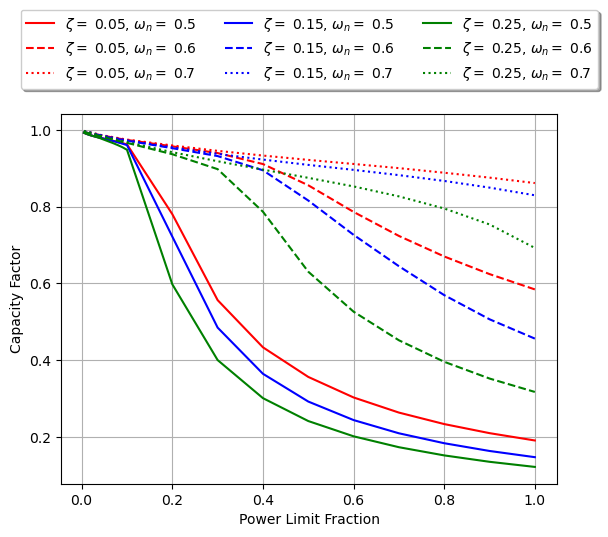

In [99]:

P_lim_list_full = np.concatenate((P_lim_list,[1]))
lens = (len(P_lim_list_full),len(zeta_range), len(omega_n_range))
P_lim_frac = np.broadcast_to(P_lim_list_full[:,None,None], lens)
CF_matrix = np.reshape(CFs, (lens[1],lens[2],lens[0])).transpose(2, 0, 1)

cols = ['r','b','g']
lines = ['-', '--', ':']
fig, ax = plt.subplots()
for z_idx in range(len(zeta_range)):
    for o_idx in range(len(omega_n_range)):
        ax.plot(P_lim_frac[:, z_idx, o_idx], CF_matrix[:, z_idx, o_idx], color=cols[z_idx], linestyle=lines[o_idx],
                label="$\zeta =$ " + str(zeta_range[z_idx]) + ", $\omega_n =$ " + str(omega_n_range[o_idx]))
ax.set_ylabel('Capacity Factor')
ax.set_xlabel('Power Limit Fraction')

ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
ax.grid()
plt.show()

In [89]:
"""
fig, ax = plt.subplots()
plt.hist(data_mod.Avail, bins=200, density=True)
plt.xlabel('Normalized Power')
plt.ylabel('Probability Density')

fig, ax = plt.subplots()
plt.hist(data_mod.Avail, bins=200, density=True)
plt.plot([0.02, 0.02],[0,12],'k--', [0.04,0.04],[0,4.5],'k--', [0.06,0.06],[0,2.2],'k--',
          [0.08,0.08],[0,1.5],'k--', [0.1,0.1],[0,1.5],'k--')
plt.xlim([0,0.12])
"""

"\nfig, ax = plt.subplots()\nplt.hist(data_mod.Avail, bins=200, density=True)\nplt.xlabel('Normalized Power')\nplt.ylabel('Probability Density')\n\nfig, ax = plt.subplots()\nplt.hist(data_mod.Avail, bins=200, density=True)\nplt.plot([0.02, 0.02],[0,12],'k--', [0.04,0.04],[0,4.5],'k--', [0.06,0.06],[0,2.2],'k--',\n          [0.08,0.08],[0,1.5],'k--', [0.1,0.1],[0,1.5],'k--')\nplt.xlim([0,0.12])\n"

In [ ]:
cap_costs = 1e3 * np.linspace(2000., 12000., 3) # USD/MW. Wind is around 1e3 * 1,600, nominal RM3 is around 1e3 * 10,000
years = [2030,2045]
P_lims = np.array([0.1, 0.4, 0.7, 1.0])

cap_cost_mesh, year_mesh = np.meshgrid(cap_costs, years)
cap_cost_vec = cap_cost_mesh.flatten()
year_vec = year_mesh.flatten()

print(cap_cost_vec)
print(year_vec)

wave_cost_str = [f"Wave_{cap_cost/1e3:.0f}" for cap_cost in cap_costs] # $k/MW
print(wave_cost_str)
wave_cost_str_repeated = np.matlib.repmat(wave_cost_str, len(years), 1).flatten()

print(wave_cost_str_repeated)

#P_lim_string = (P_lim_vec*1000).astype(int).astype(str)
#keys = np.char.add( np.repeat("Avail_limited_",np.size(P_lim_vec)), P_lim_string )
#print(keys)

# use CF to lookup power limit and corresponding availability timeseries

[500000. 700000. 900000. 500000. 700000. 900000.]
[2030 2030 2030 2045 2045 2045]
['Wave_500', 'Wave_700', 'Wave_900']
['Wave_500' 'Wave_700' 'Wave_900' 'Wave_500' 'Wave_700' 'Wave_900']


In [91]:
# make a separate csv per profile
variability_names = []
location_folder = cem_dir + '/data_east/'
profile_folder = location_folder + 'wave_profiles/'
if not os.path.exists(profile_folder):
    os.makedirs(profile_folder)

csv_num = 0

for d_idx in range(len(float_diam_range)):
    for P_limit in P_lims:
        for z_idx in range(len(zeta_range)):
            for o_idx in range(len(omega_n_range)):
                key_unlimited = "Avail_zeta_" + str(zeta_range[z_idx]) + "_omega_n_" + str(omega_n_range[o_idx]) + "_D_f_" + str(float_diam_range[d_idx])
                key_limited = key_unlimited + "_limited_" + str(int(P_limit*1000))
                if P_limit == 1:
                    key = key_unlimited
                else:
                    key = key_limited
                profile_data = data_mod[key].values
                profile_hourly = np.interp(np.arange(0, 8760), np.arange(0, 8760, 3), profile_data)

                csv_data = pd.DataFrame()
                csv_data["technology"] = wave_cost_str_repeated
                csv_data["planning_year"] = year_vec
                csv_data["capex_mw"] = cap_cost_vec
                csv_data["capex_mwh"] = 0
                csv_data["fixed_o_m_mw"] = cap_cost_vec / 10
                csv_data["fixed_o_m_mwh"] = 0
                csv_data["variable_o_m_mwh"] = 0
                csv_data["wacc_real"] = 0.07
                csv_data["dollar_year"] = 2014
                csv_data["heat_rate"] = 0
                csv_data["profile"] = np.array2string(profile_hourly, separator=',', precision=4, threshold=np.inf)

                csv_data.to_csv(profile_folder + key_limited +'.csv',index=False)
                variability_names.append(key_limited)
                csv_num += 1
                print(f"Wrote profile csv {csv_num} of {len(float_diam_range) * len(P_lims) * len(zeta_range) * len(omega_n_range)}")

csv_data.head()


Wrote profile csv 1 of 36
Wrote profile csv 2 of 36
Wrote profile csv 3 of 36
Wrote profile csv 4 of 36
Wrote profile csv 5 of 36
Wrote profile csv 6 of 36
Wrote profile csv 7 of 36
Wrote profile csv 8 of 36
Wrote profile csv 9 of 36
Wrote profile csv 10 of 36
Wrote profile csv 11 of 36
Wrote profile csv 12 of 36
Wrote profile csv 13 of 36
Wrote profile csv 14 of 36
Wrote profile csv 15 of 36
Wrote profile csv 16 of 36
Wrote profile csv 17 of 36
Wrote profile csv 18 of 36
Wrote profile csv 19 of 36
Wrote profile csv 20 of 36
Wrote profile csv 21 of 36
Wrote profile csv 22 of 36
Wrote profile csv 23 of 36
Wrote profile csv 24 of 36
Wrote profile csv 25 of 36
Wrote profile csv 26 of 36
Wrote profile csv 27 of 36
Wrote profile csv 28 of 36
Wrote profile csv 29 of 36
Wrote profile csv 30 of 36
Wrote profile csv 31 of 36
Wrote profile csv 32 of 36
Wrote profile csv 33 of 36
Wrote profile csv 34 of 36
Wrote profile csv 35 of 36
Wrote profile csv 36 of 36


,technology,planning_year,capex_mw,capex_mwh,fixed_o_m_mw,fixed_o_m_mwh,variable_o_m_mwh,wacc_real,dollar_year,heat_rate,profile
0,Wave_500,2030,500000.0,0,50000.0,0,0,0.07,2014,0,"[9.6450e-01,9.5961e-01,9.5473e-01,9.4984e-01,9..."
1,Wave_700,2030,700000.0,0,70000.0,0,0,0.07,2014,0,"[9.6450e-01,9.5961e-01,9.5473e-01,9.4984e-01,9..."
2,Wave_900,2030,900000.0,0,90000.0,0,0,0.07,2014,0,"[9.6450e-01,9.5961e-01,9.5473e-01,9.4984e-01,9..."
3,Wave_500,2045,500000.0,0,50000.0,0,0,0.07,2014,0,"[9.6450e-01,9.5961e-01,9.5473e-01,9.4984e-01,9..."
4,Wave_700,2045,700000.0,0,70000.0,0,0,0.07,2014,0,"[9.6450e-01,9.5961e-01,9.5473e-01,9.4984e-01,9..."


In [92]:
# make a scenario inputs csv

# grid scenarios (2 dof, 3 options each): electrification, carbon_constraint
# year (1 dof, 2 options)
# design scenarios (2 dof capturing 4 dof, with 3, 4, 5, and 3 options): wave variability (zeta, omega_n, and power limit), wave cost

# total 9 grid scenarios, 2 years, 180 design scenarios = 3240 scenario rows

electrification = ['ref','med','high']
carbon_constraint = ['low','med','high']
scenario_vals = (electrification, carbon_constraint, variability_names, wave_cost_str) # all possible values, for yaml

# values to use in this sweep
indices_in_use = [[0],[1],range(len(variability_names)),range(len(wave_cost_str))]
#indices_in_use = [[0],[1],[0],range(len(wave_cost_str))] # single variability
idx_years_used = 0
scenario_vals_used = tuple(
    [[scenario_vals[i][idx] for idx in idx_list] for i, idx_list in enumerate(indices_in_use)]
)
scenario_mesh_tuple = np.meshgrid(years[idx_years_used], *scenario_vals_used, indexing='ij')

scenario_col_names = ['year', 'electrification', 'carbon_constraint', 'wave_variability', 'wave_cost']

scenario_inputs = pd.DataFrame()
num_scenarios = len(scenario_mesh_tuple[0].flatten())



scenario_inputs[scenario_col_names] = np.array([scenario_col.flatten() for scenario_col in scenario_mesh_tuple]).T

#scenario_inputs["case_id"] = ['Case_' + str(i) for i in np.arange(1, num_scenarios + 1)]
scenario_inputs["case_id"] = ['Case_' + str('_'.join(str(k) + '_' + str(v) for k, v in row.items())) for row in scenario_inputs.to_dict('records')]

print(len(scenario_inputs))
scenario_inputs.head()
scenario_inputs.to_csv(location_folder + 'scenario_input.csv',index=False)


108


In [93]:
# make a settings management for power genome

pg_settings_names = ['electrification_scenario', 'emission_policies_fn', 'additional_technologies_fn', 'additional_new_gen']

elec_val_names = ['REFERENCE ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT', 'MEDIUM ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT', 'HIGH ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT']
carbon_val_names = ['emission_policies_net_zero.csv','emission_policies.csv','emission_policies_no_limit.csv']
wave_var_names = ['wave_profiles/' + key + '.csv' for key in variability_names]
wave_cost_val_names = [[str] for str in wave_cost_str] # turn list of strs into list of lists

pg_val_names = [elec_val_names, carbon_val_names, wave_var_names, wave_cost_val_names]

idxs = range(len(scenario_col_names)-1)
scenario_inner_dicts = [dict(zip(scenario_vals[i], \
                               [{pg_settings_names[i]:val} for val in pg_val_names[i]] \
                             )) for i in idxs]
scenario_dict = dict(zip(scenario_col_names[1:], scenario_inner_dicts))
settings_management = {'settings_management': {year: scenario_dict for year in years}}

print(f"scenario inner dicts: {scenario_inner_dicts}")
print(f"scenario dict: {scenario_dict}")
print(f"settings management: {settings_management}")

with open(location_folder + 'settings/settings_management.yml', 'w') as f:
    yaml.dump(settings_management, f, sort_keys=False)



scenario inner dicts: [{'ref': {'electrification_scenario': 'REFERENCE ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT'}, 'med': {'electrification_scenario': 'MEDIUM ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT'}, 'high': {'electrification_scenario': 'HIGH ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT'}}, {'low': {'emission_policies_fn': 'emission_policies_net_zero.csv'}, 'med': {'emission_policies_fn': 'emission_policies.csv'}, 'high': {'emission_policies_fn': 'emission_policies_no_limit.csv'}}, {'Avail_zeta_0.05_omega_n_0.5_D_f_20_limited_100': {'additional_technologies_fn': 'wave_profiles/Avail_zeta_0.05_omega_n_0.5_D_f_20_limited_100.csv'}, 'Avail_zeta_0.05_omega_n_0.6_D_f_20_limited_100': {'additional_technologies_fn': 'wave_profiles/Avail_zeta_0.05_omega_n_0.6_D_f_20_limited_100.csv'}, 'Avail_zeta_0.05_omega_n_0.7_D_f_20_limited_100': {'additional_technologies_fn': 'wave_profiles/Avail_zeta_0.05_omega_n_0.7_D_f_20_limited_100.csv'}, 'Avail_zeta_0.15_omega_n_0.5_D_f_20_

In [94]:
# make a cost multiplier yaml for power genome
def update_cost_mult_yaml(yaml_file_path, new_yaml_path, anchor_name="offshore_wind"):
    """
    Update the YAML file with new offshore wind technologies.
    
    Args:
        yaml_file_path (str or Path): Path to the YAML file
        new_yaml_path (str or Path): Path to save the updated YAML file
        anchor_name (str): Name of the YAML anchor to update
    """
    yaml_file_path = Path(yaml_file_path)
    new_yaml_path = Path(new_yaml_path)
    
    # Generate the new offshore wind list
    offshore_wind_list = ["OffShoreWind_Class3"] + wave_cost_str
    print(f"Generated offshore wind list: {offshore_wind_list}")
    
    # Read the current file
    with open(yaml_file_path, 'r') as f:
        content = f.read()
    
    print(f"Original file size: {len(content)} characters")
    print(f"Looking for anchor: {anchor_name}")
    
    # Check if the anchor exists in the file
    anchor_pattern = f'{anchor_name}: &{anchor_name}'
    if anchor_pattern not in content:
        print(f"Warning: Anchor '{anchor_pattern}' not found in file!")
        print("Available content preview:")
        print(content[:500] + "..." if len(content) > 500 else content)
        return
    
    # Improved pattern to match the offshore wind anchor section
    # This matches from the anchor definition to the end of the list
    pattern = rf'({anchor_name}: &{anchor_name}\n)(.*?)(?=\n\S|\n*$)' 
    
    # Create the new YAML section
    new_section = f"{anchor_name}: &{anchor_name}\n"
    for tech in offshore_wind_list:
        new_section += f"  - {tech}\n"
    
    print(f"New section to insert:\n{new_section}")
    
    # Replace the section
    new_content = re.sub(pattern, new_section.rstrip() + '\n', content, flags=re.DOTALL)
    
    # Write back to file
    with open(new_yaml_path, 'w') as f:
        f.write(new_content)

update_cost_mult_yaml(cem_dir + '/template/cost_mult_tech_map.yml', location_folder + '/settings/cost_mult_tech_map_updated.yml')

Generated offshore wind list: ['OffShoreWind_Class3', 'Wave_500', 'Wave_700', 'Wave_900']
Original file size: 1965 characters
Looking for anchor: offshore_wind
New section to insert:
offshore_wind: &offshore_wind
  - OffShoreWind_Class3
  - Wave_500
  - Wave_700
  - Wave_900



using Pkg
Pkg.activate("GenX")
]
include("caserunner.jl")